In [33]:
import torch
import torch.nn as nn

import numpy as np
import copy

import matplotlib.pyplot as plt

In [34]:
%config InlineBackend.figure_format = 'retina'

In [35]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
import sine_data_generator
import models.encoder
import models.decoder

from sine_data_generator import SineDataGenerator
from models.encoder import IOPairSetEncoder
from models.decoder import Decoder
from models.lpn import LPN
from models.utils import relu_seq, ReluNet, make_leave_one_out

In [38]:
data_gen = SineDataGenerator(10, 16)

inputs_np, outputs_np, amp_np, phase_np = data = data_gen.generate()
xs, outputs_pred, amp, phase = [torch.Tensor(arr) for arr in data]

In [39]:
xs.shape, outputs_pred.shape, amp.shape, phase.shape

(torch.Size([16, 10, 1]),
 torch.Size([16, 10, 1]),
 torch.Size([16]),
 torch.Size([16]))

### Modules

#### Encoder

In [40]:
io_pairs = torch.cat([xs, outputs_pred], dim=-1)  # (batch_size, N, 2)
io_pairs.shape

torch.Size([16, 10, 2])

In [41]:
set_encoder = IOPairSetEncoder()
z_mu, z_logvar = set_encoder(io_pairs)
z_sample = z_mu
z_sample.shape  # (batch_size, output_dim)

torch.Size([16, 3])

In [42]:
set_encoder

IOPairSetEncoder(
  (phi): ReluNet(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    )
  )
  (rho_0): ReluNet(
    (net): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=16, bias=True)
    )
  )
  (rho_1): ReluNet(
    (net): Sequential(
      (0): Linear(in_features=16, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=3, bias=True)
    )
  )
  (rho_2): ReluNet(
    (net): Sequential(
      (0): Linear(in_features=16, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=3, bias=True)
    )
  )
)

#### Decoder

In [43]:
z_sample.shape, xs.shape

(torch.Size([16, 3]), torch.Size([16, 10, 1]))

In [44]:
input_0 = xs[:, 0, :]  # (batch_size, d_input)
input_0.shape

torch.Size([16, 1])

In [45]:
z_expanded = z_sample.unsqueeze(1).expand(-1, xs.size(1), -1)
z_inputs = torch.cat([z_expanded, xs], axis=-1)
z_inputs.shape

torch.Size([16, 10, 4])

In [46]:
decoder = Decoder()
decoder

Decoder(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [47]:
decoder(z_inputs).shape

torch.Size([16, 10, 1])

### Utils

In [48]:
def make_leave_one_out(array: torch.Tensor, axis: int) -> torch.Tensor:
    """
    Args:
        array: Tensor of shape (*B, N, *H).
        axis: The axis where N appears.

    Returns:
        Tensor of shape (*B, N, N-1, *H).
    """
    axis = axis % array.ndim
    n = array.size(axis)
    output = []

    for i in range(n):
        array_before = array.narrow(axis, 0, i)
        array_after = array.narrow(axis, i + 1, n - i - 1)
        sliced = torch.cat([array_before, array_after], dim=axis)
        output.append(sliced)

    output = torch.stack(output, dim=axis)
    return output

In [49]:
# Create a random tensor
random_array = torch.randn(4, 5, 6)  # Example shape (4, 5, 6)

# Apply the make_leave_one_out function
leave_one_out_result = make_leave_one_out(random_array, axis=1)

# Print the shapes to verify
print("Original shape:", random_array.shape)
print("Leave-one-out shape:", leave_one_out_result.shape)

Original shape: torch.Size([4, 5, 6])
Leave-one-out shape: torch.Size([4, 5, 4, 6])


In [50]:
random_array[0, :, :]

tensor([[-1.2445, -1.9047,  1.0075, -2.0299, -1.2347, -0.5570],
        [-0.7741,  0.6716,  0.8801,  0.0924,  2.2735,  0.2846],
        [ 0.5475,  1.0939,  1.1174,  0.0086,  0.0124, -1.6234],
        [-1.9776,  0.1147,  0.1172, -1.2986,  0.9240,  0.1987],
        [-2.7388, -0.3303,  0.2065, -0.3761, -0.0858,  1.5565]])

In [51]:
leave_one_out_result[0, 0, :, :]

tensor([[-0.7741,  0.6716,  0.8801,  0.0924,  2.2735,  0.2846],
        [ 0.5475,  1.0939,  1.1174,  0.0086,  0.0124, -1.6234],
        [-1.9776,  0.1147,  0.1172, -1.2986,  0.9240,  0.1987],
        [-2.7388, -0.3303,  0.2065, -0.3761, -0.0858,  1.5565]])

### [WIP] LPN

In [52]:
# z: (H,)
# inputs: (B, 1)
B = 3  # Batch size
N = 5
H = 7  # Latent dimension

# Generate random z and inputs
z_init = torch.randn(H)  # Random latent variables of shape (B, H)
xs = torch.randn(B, 1)  # Random inputs of shape (B, 1)

# z_expanded = z.unsqueeze(0).expand(B, -1)
z_init.unsqueeze(0).expand(B, -1).shape

torch.Size([3, 7])

In [53]:
torch.manual_seed(0)
ys_1 = torch.randn(B, N, N-1, 1)
ys_2 = torch.randn(B, N, N-1, 1)
mse = nn.functional.mse_loss(ys_1, ys_2, reduction='none') # (B, N, 1)
mse.sum(dim=-2).shape

torch.Size([3, 5, 1])

In [54]:
z_init = torch.randn(B, N, H)
z_init.unsqueeze(2).expand(-1, -1, N-1, -1).shape

torch.Size([3, 5, 4, 7])

### Training

In [55]:
import wandb
wandb.init(settings=wandb.Settings(save_code=False))
wandb.finish()
wandb.init(project="lpn4sine")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_tasks = 10_000
n_samples_per_task = 10
batch_size = 16

K = 1

data_gen = SineDataGenerator(n_samples_per_task, batch_size)

d_latent = 2
# alpha = .1

# Init encoder-decoder
encoder = IOPairSetEncoder(phi=ReluNet(2, 32, 32),
                           rho_0=ReluNet(32, 32, 16),
                           rho_1=ReluNet(16, 8, d_latent))
decoder = Decoder(d_input=1, d_latent=d_latent, ds_hidden=[32, 32], d_output=1)

lpn = LPN(d_input=1,
          d_output=1,
          d_latent=d_latent,
          encoder=encoder,
          decoder=decoder).to(device)

optimizer = torch.optim.AdamW(lpn.parameters(), lr=1e-3)

losses = []

for i in range(n_tasks):
    lpn.train()
    optimizer.zero_grad()

    xs, ys, amp, phase = data_gen.generate()
    io_pairs = torch.cat([xs, ys], dim=-1).to(device)  # (B, N, 2)

    _, loss = lpn(io_pairs, K=K)

    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        print(f"Step {i}, Loss: {loss.item():.4f}")
        wandb.log({"loss": loss.item()})
        losses.append(loss.item())


wandb.finish()

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Step 0, Loss: 2.6654
Step 100, Loss: 2.0400
Step 200, Loss: 1.4648
Step 300, Loss: 1.2289
Step 400, Loss: 1.1504
Step 500, Loss: 1.2714
Step 600, Loss: 1.5628
Step 700, Loss: 1.9641
Step 800, Loss: 0.9942
Step 900, Loss: 0.8830
Step 1000, Loss: 1.2906
Step 1100, Loss: 0.8963
Step 1200, Loss: 0.7225
Step 1300, Loss: 0.8043
Step 1400, Loss: 0.3999
Step 1500, Loss: 0.4457
Step 1600, Loss: 0.3415
Step 1700, Loss: 0.3865
Step 1800, Loss: 0.3318
Step 1900, Loss: 0.2525
Step 2000, Loss: 0.3858
Step 2100, Loss: 0.3603
Step 2200, Loss: 0.3023
Step 2300, Loss: 0.2529
Step 2400, Loss: 0.2266
Step 2500, Loss: 0.4890
Step 2600, Loss: 0.3614
Step 2700, Loss: 0.2539
Step 2800, Loss: 0.3412
Step 2900, Loss: 0.3631
Step 3000, Loss: 0.2468
Step 3100, Loss: 0.1813
Step 3200, Loss: 0.2990
Step 3300, Loss: 0.2566
Step 3400, Loss: 0.2075
Step 3500, Loss: 0.2623
Step 3600, Loss: 0.1506
Step 3700, Loss: 0.2959
Step 3800, Loss: 0.1960
Step 3900, Loss: 0.2100
Step 4000, Loss: 0.1462
Step 4100, Loss: 0.2128
Step

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


loss,█▆▅▄▃▃▂▂▁▂▂▂▂▁▁▁▁▁▂▁▁▁▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁
loss,0.1488


In [56]:
# wandb.finish()

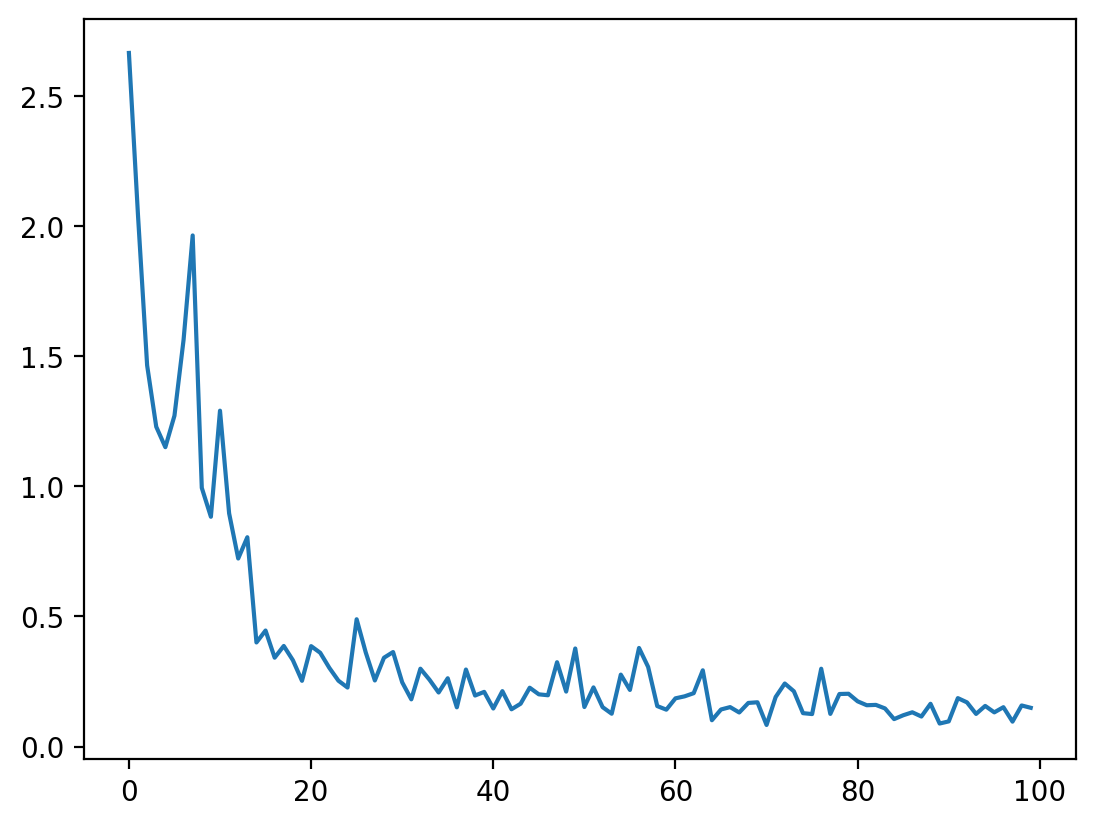

In [57]:
plt.plot(losses)
plt.show()

### Save/reload weights

In [58]:
torch.save(lpn.state_dict(), f'lpn_H{d_latent}_GA{K}.pth')

In [59]:
lpn = LPN(d_input=1,
          d_output=1,
          d_latent=d_latent,
          encoder=encoder,
          decoder=decoder).to(device)
state_dict = torch.load(f'lpn_H{d_latent}_GA{K}.pth')
lpn.load_state_dict(state_dict, strict=False)

<All keys matched successfully>

### Micro-validation

In [60]:
sample_xs, sample_ys, amp, phase = SineDataGenerator(10, 1).generate()

amp = amp.item()
phase = phase.item()

sample_xs.shape

torch.Size([1, 10, 1])

In [65]:
io_pairs_t = torch.cat([sample_xs, sample_ys], dim=-1).to(device)  # (B, N, 2)
aux_t, loss_t = lpn(io_pairs_t, K=200, debug=True)

y_pred = aux_t["ys_pred"].detach().cpu().numpy()
z_mu = aux_t["z_mu"].detach()
z_logvar = aux_t["z_logvar"].detach()
z_sample = aux_t["z_sample"].detach()
z_prime = aux_t["z_prime"].detach()

torch.sum(mse).item()=34.09320068359375
torch.sum(mse).item()=27.195241928100586
torch.sum(mse).item()=21.85491180419922
torch.sum(mse).item()=17.852924346923828
torch.sum(mse).item()=14.834786415100098
torch.sum(mse).item()=12.549891471862793
torch.sum(mse).item()=10.878182411193848
torch.sum(mse).item()=9.618252754211426
torch.sum(mse).item()=8.669098854064941
torch.sum(mse).item()=7.9207844734191895
torch.sum(mse).item()=7.347499847412109
torch.sum(mse).item()=6.894000053405762
torch.sum(mse).item()=6.5231428146362305
torch.sum(mse).item()=6.210165977478027
torch.sum(mse).item()=5.937753677368164
torch.sum(mse).item()=5.694766044616699
torch.sum(mse).item()=5.475494861602783
torch.sum(mse).item()=5.2711710929870605
torch.sum(mse).item()=5.079256534576416
torch.sum(mse).item()=4.901695251464844
torch.sum(mse).item()=4.735004901885986
torch.sum(mse).item()=4.57808780670166
torch.sum(mse).item()=4.430240631103516
torch.sum(mse).item()=4.290562152862549
torch.sum(mse).item()=4.157602310

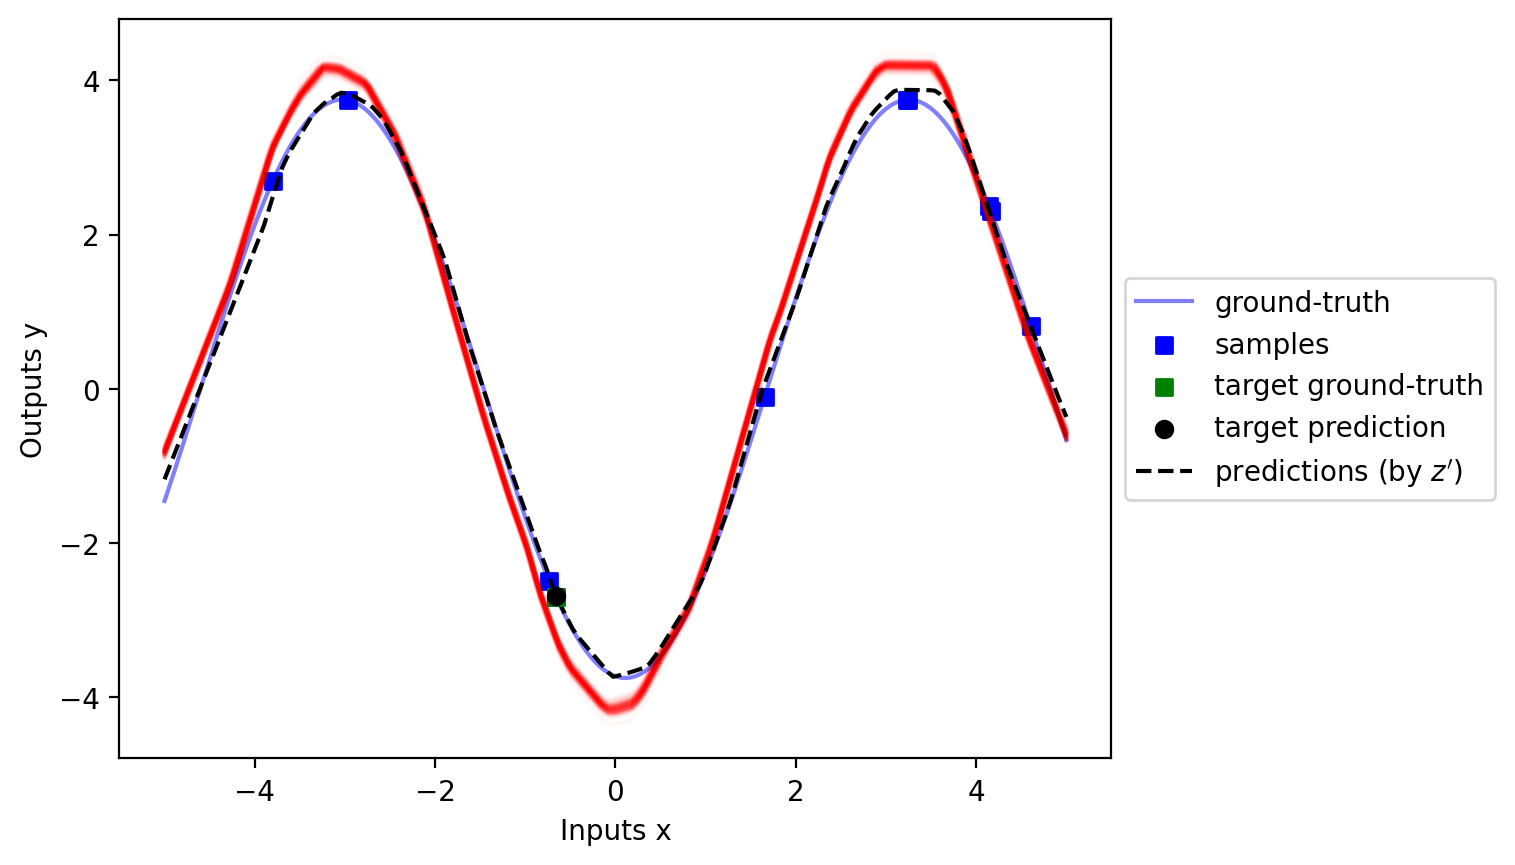

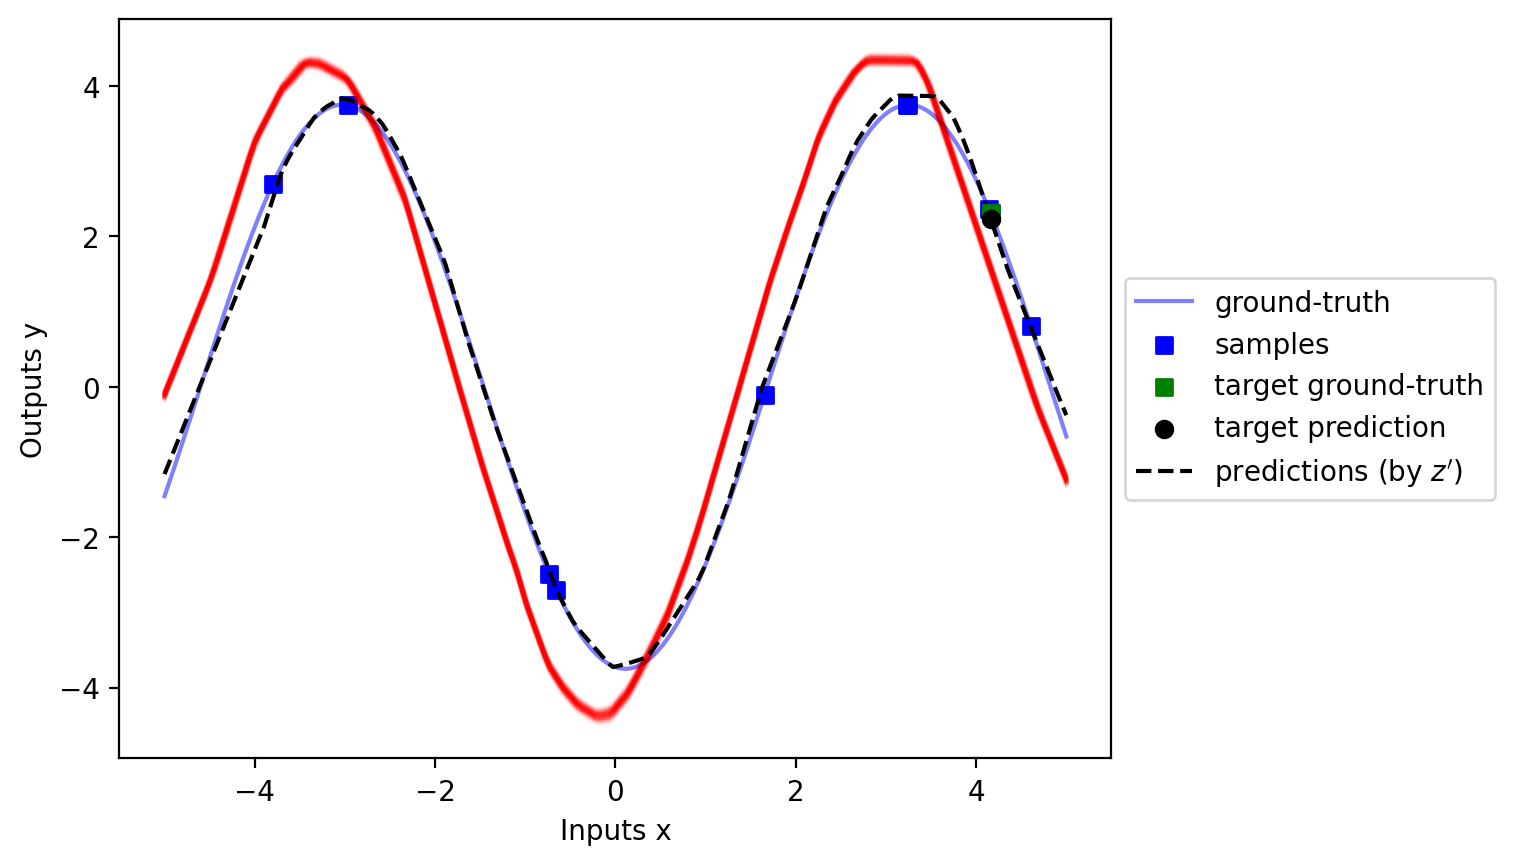

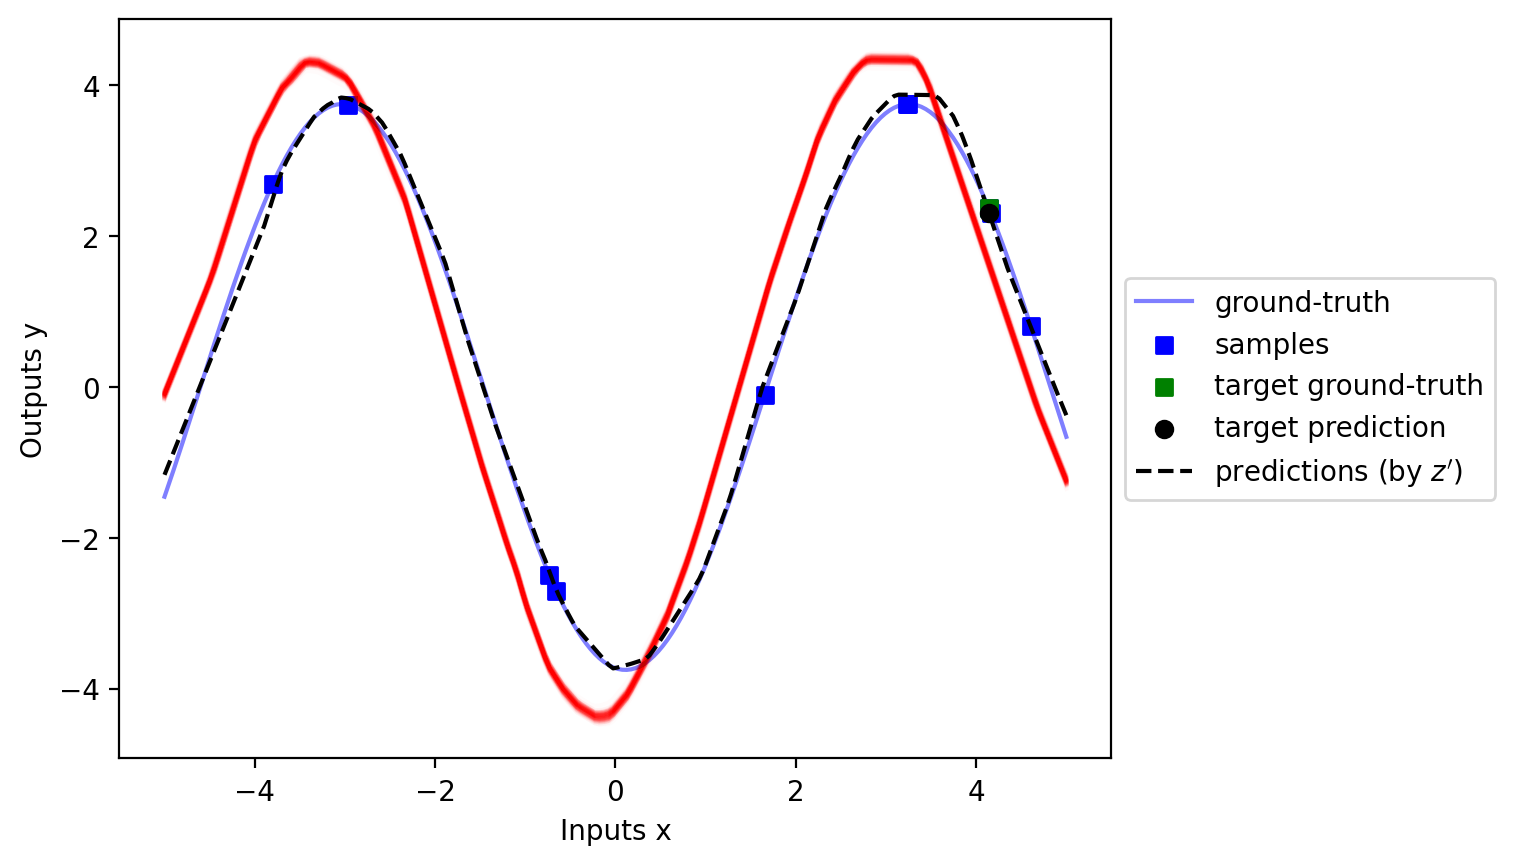

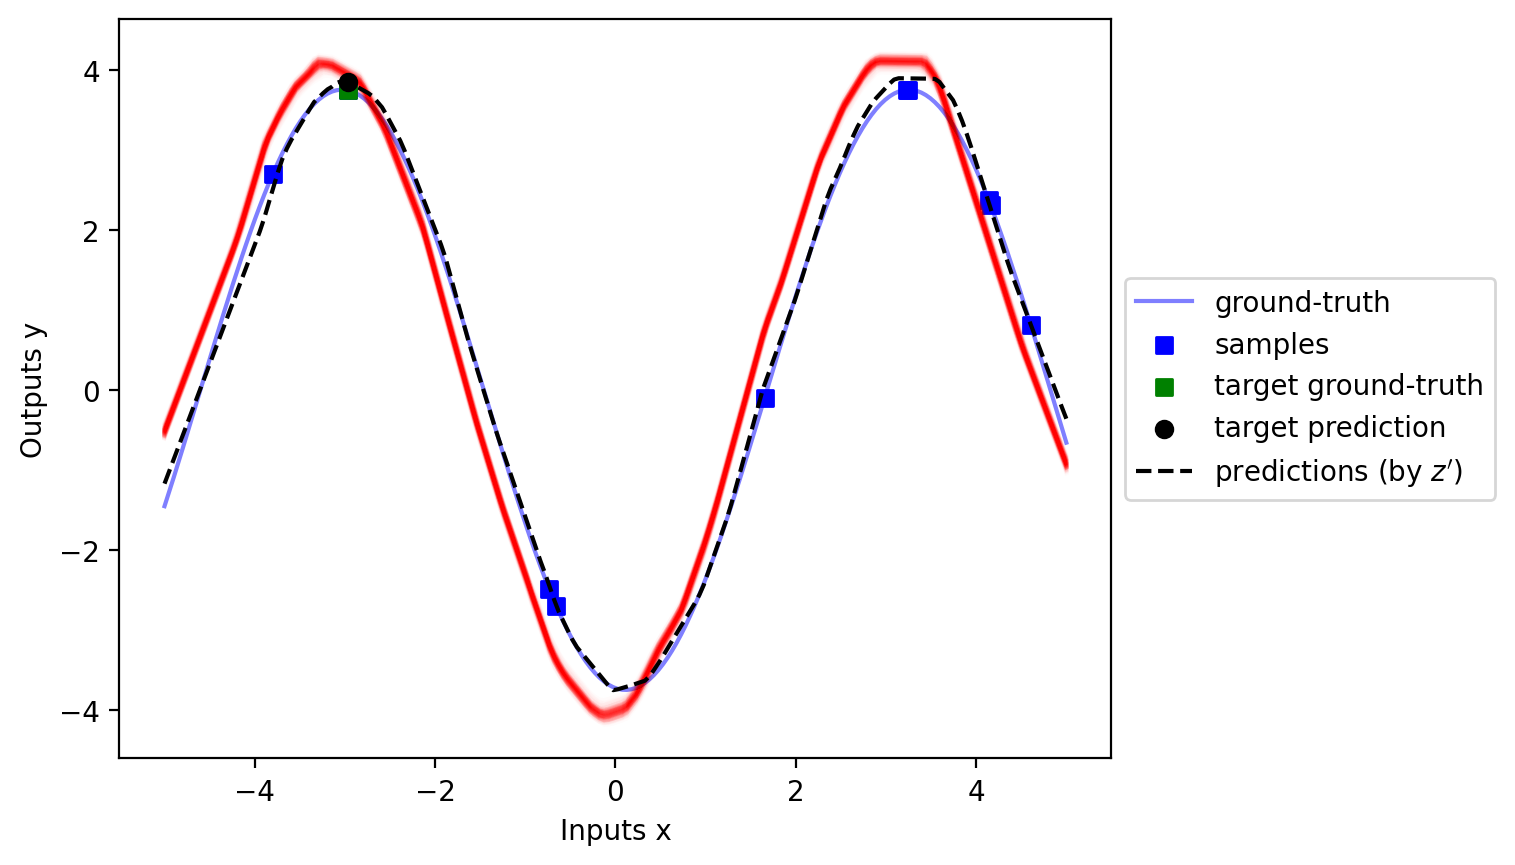

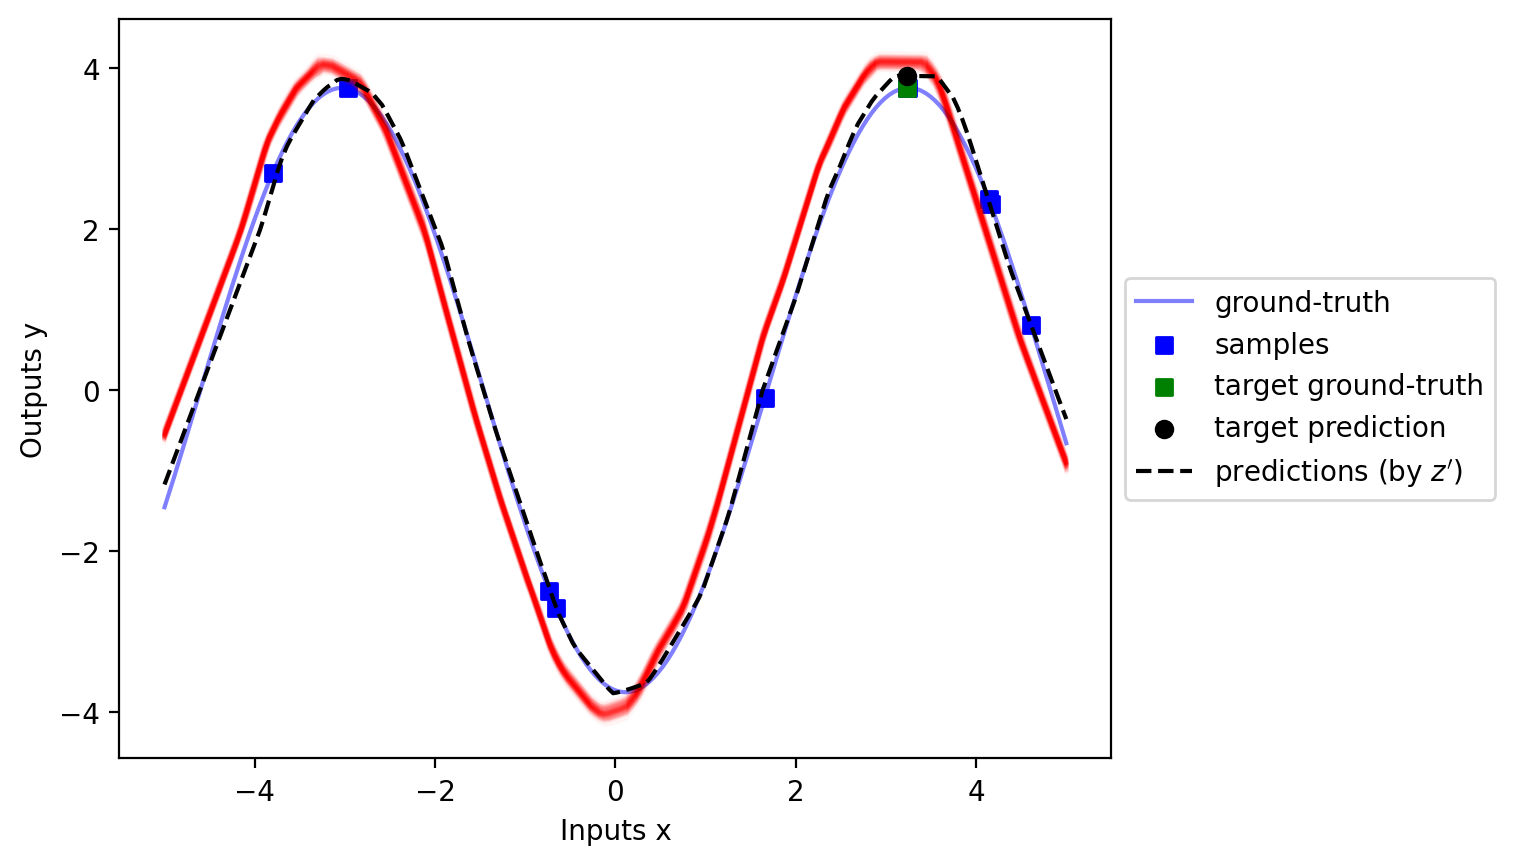

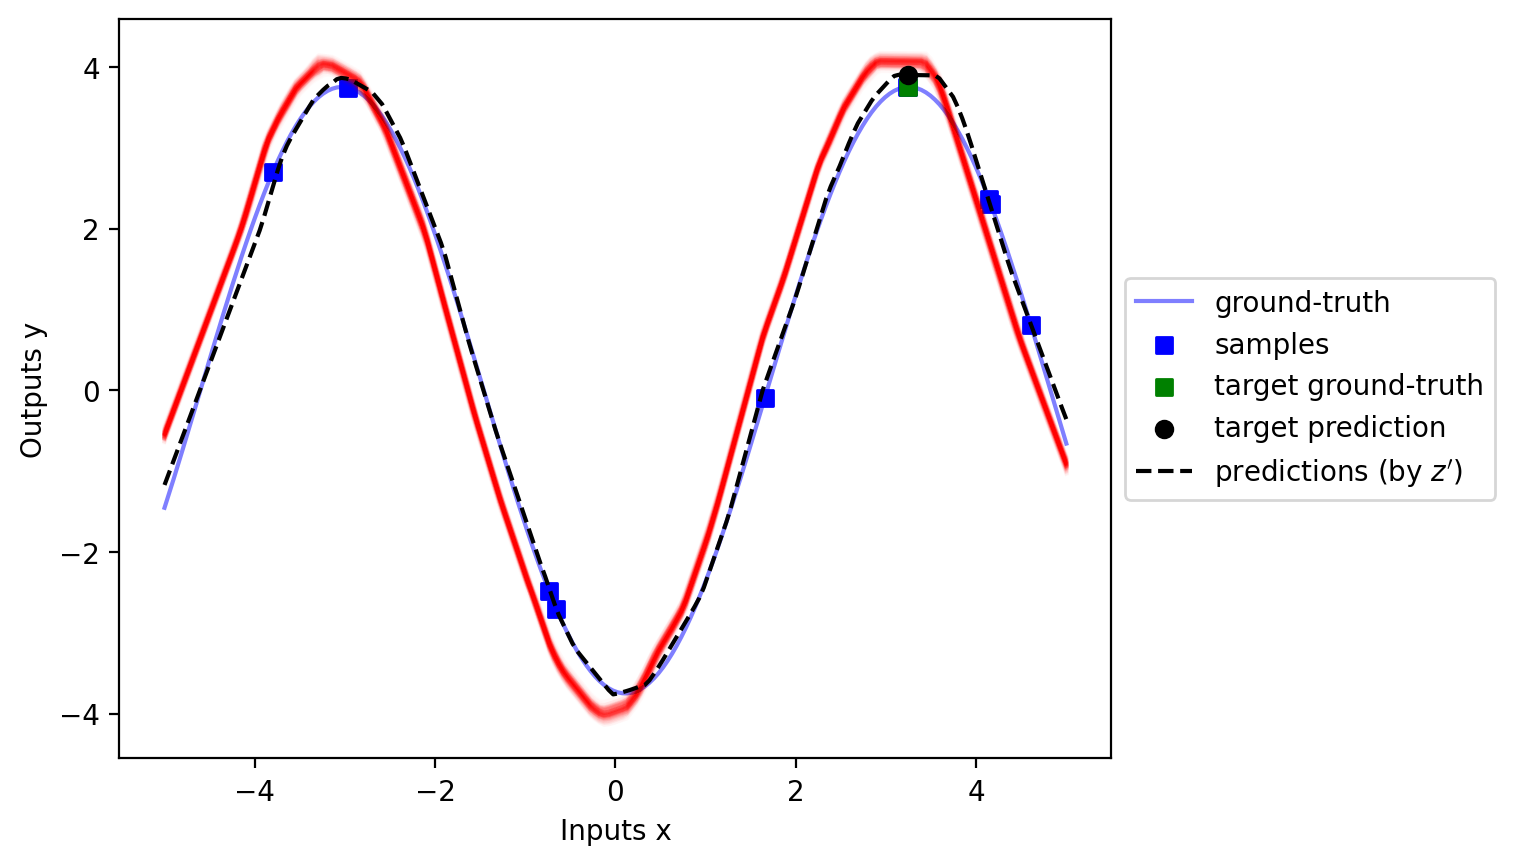

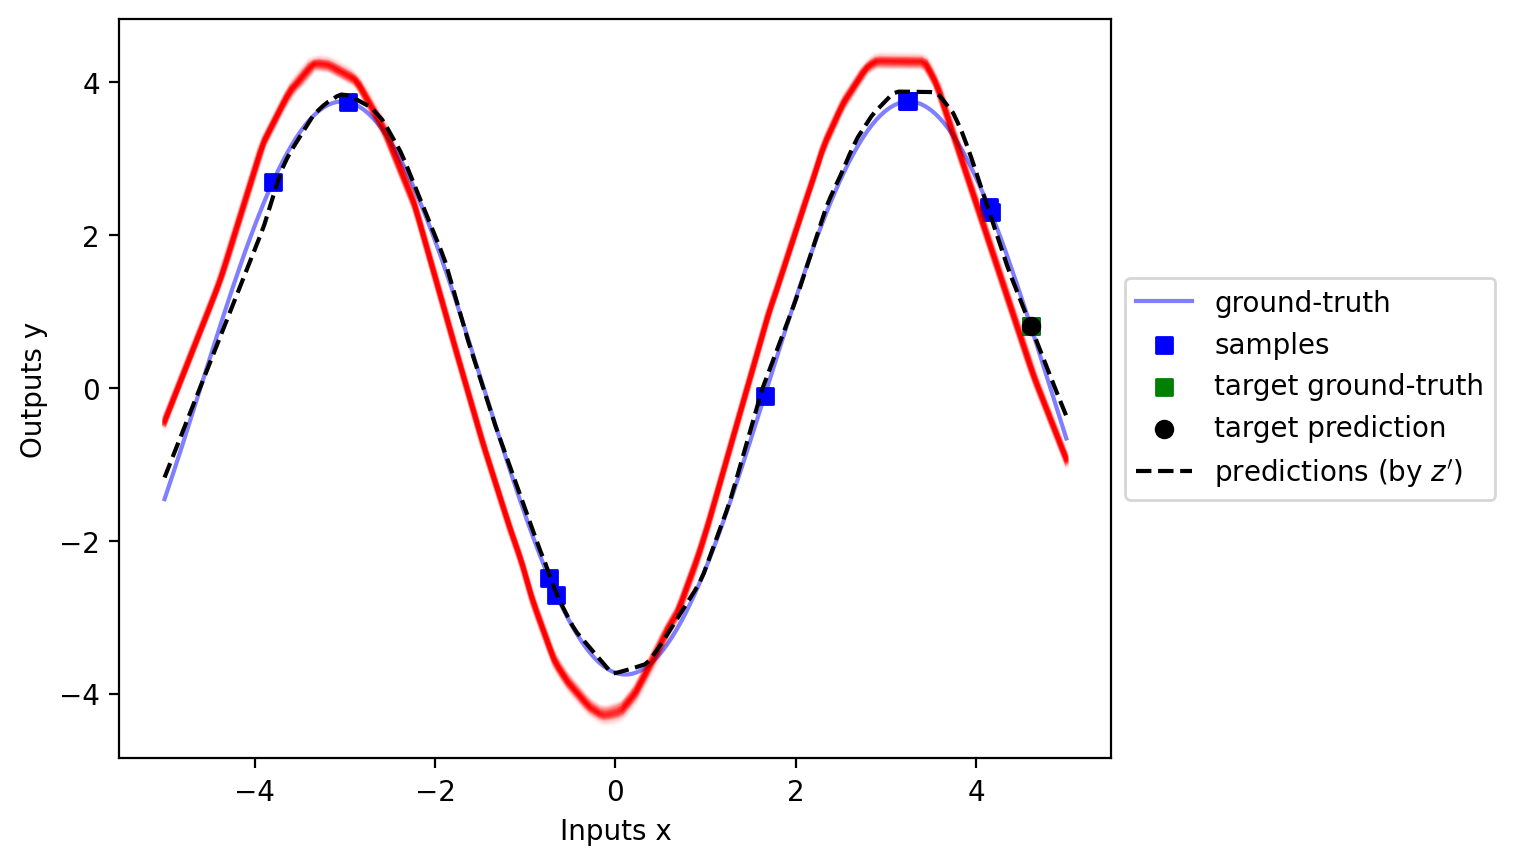

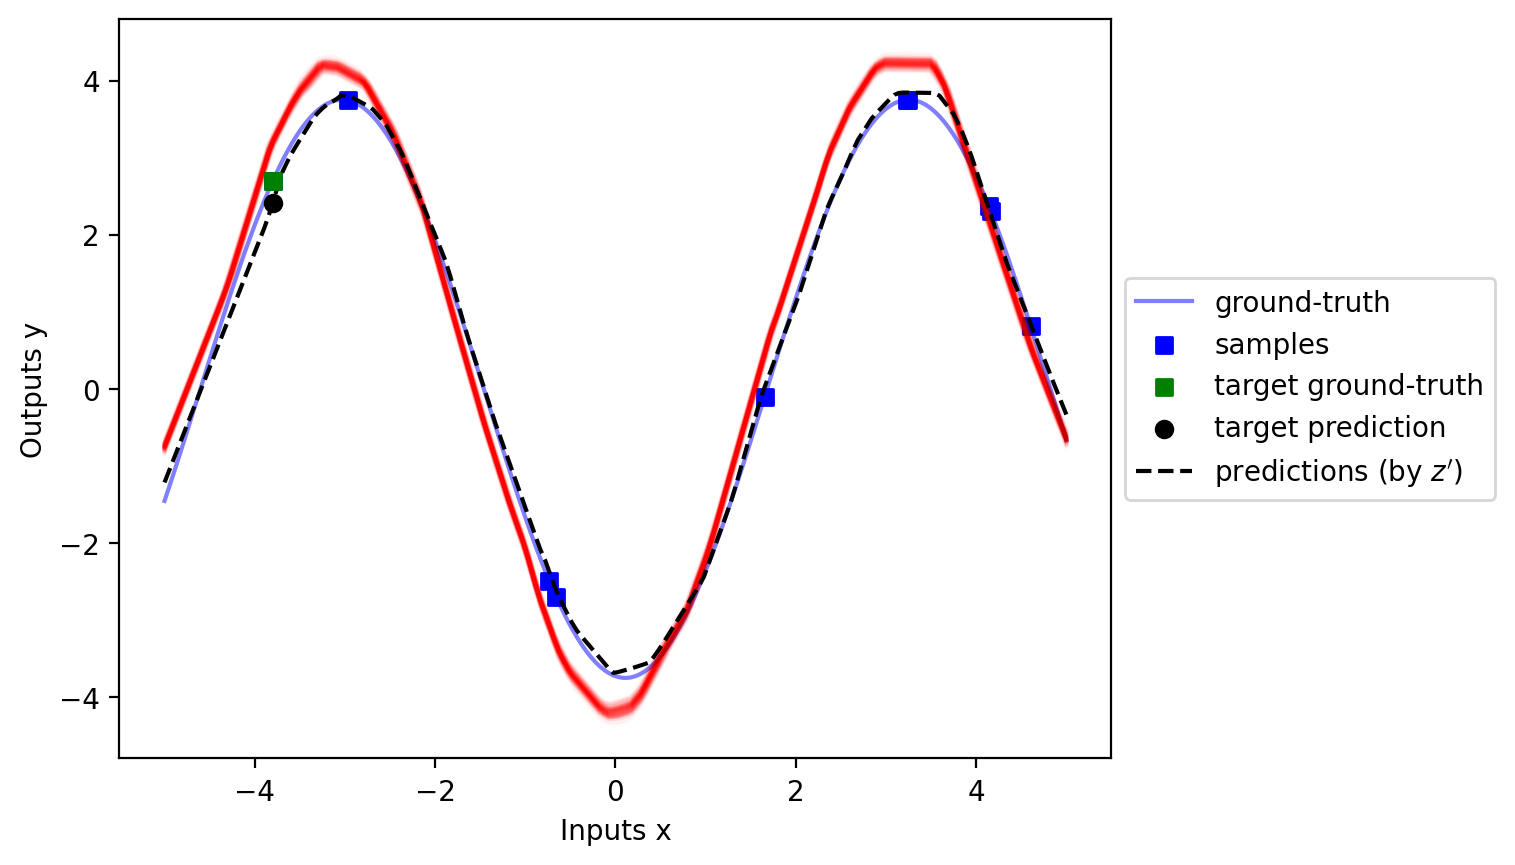

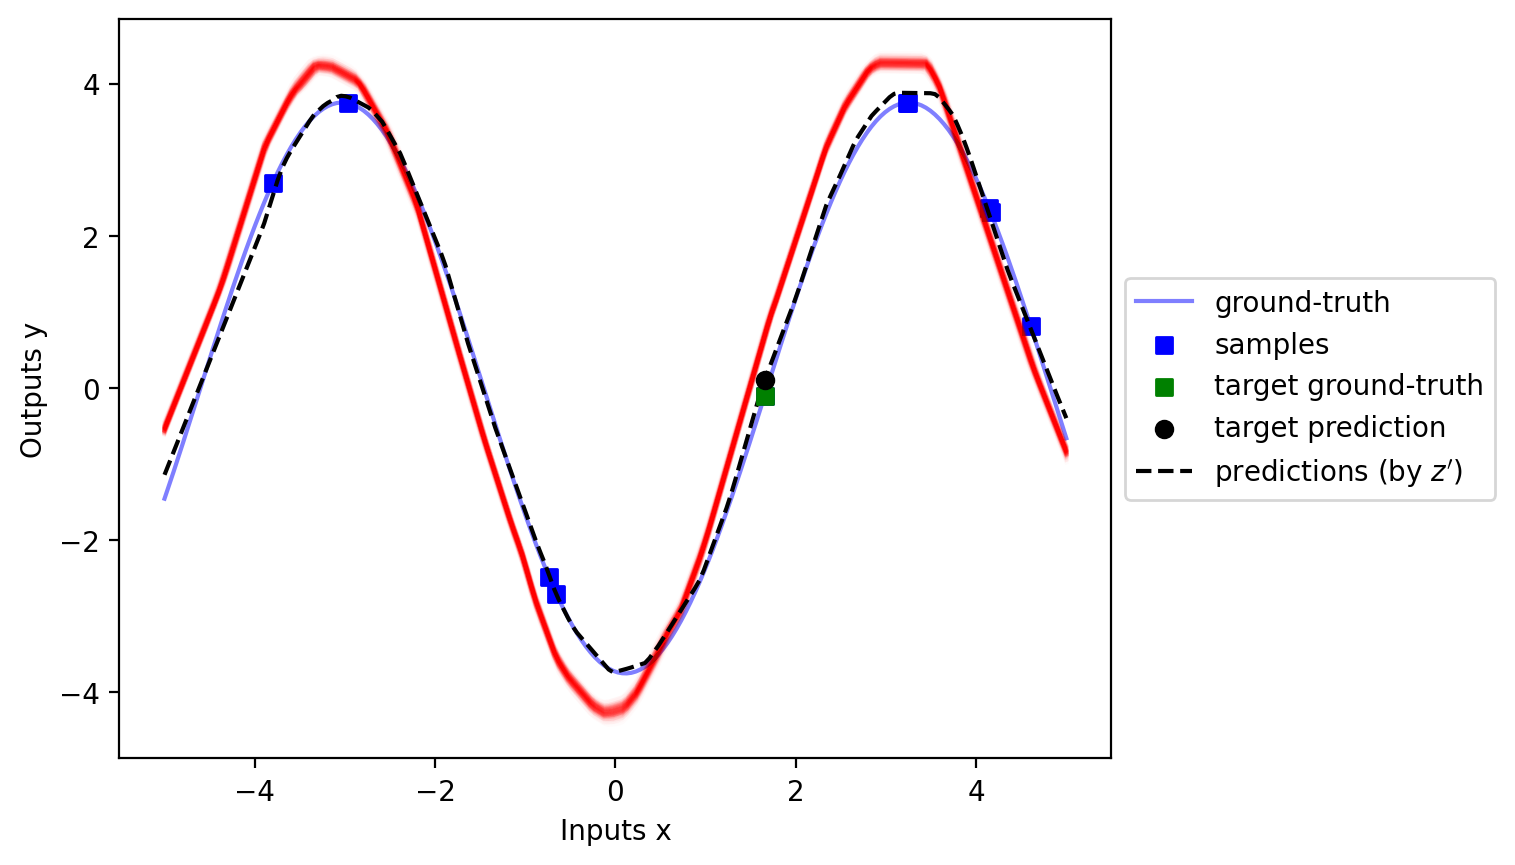

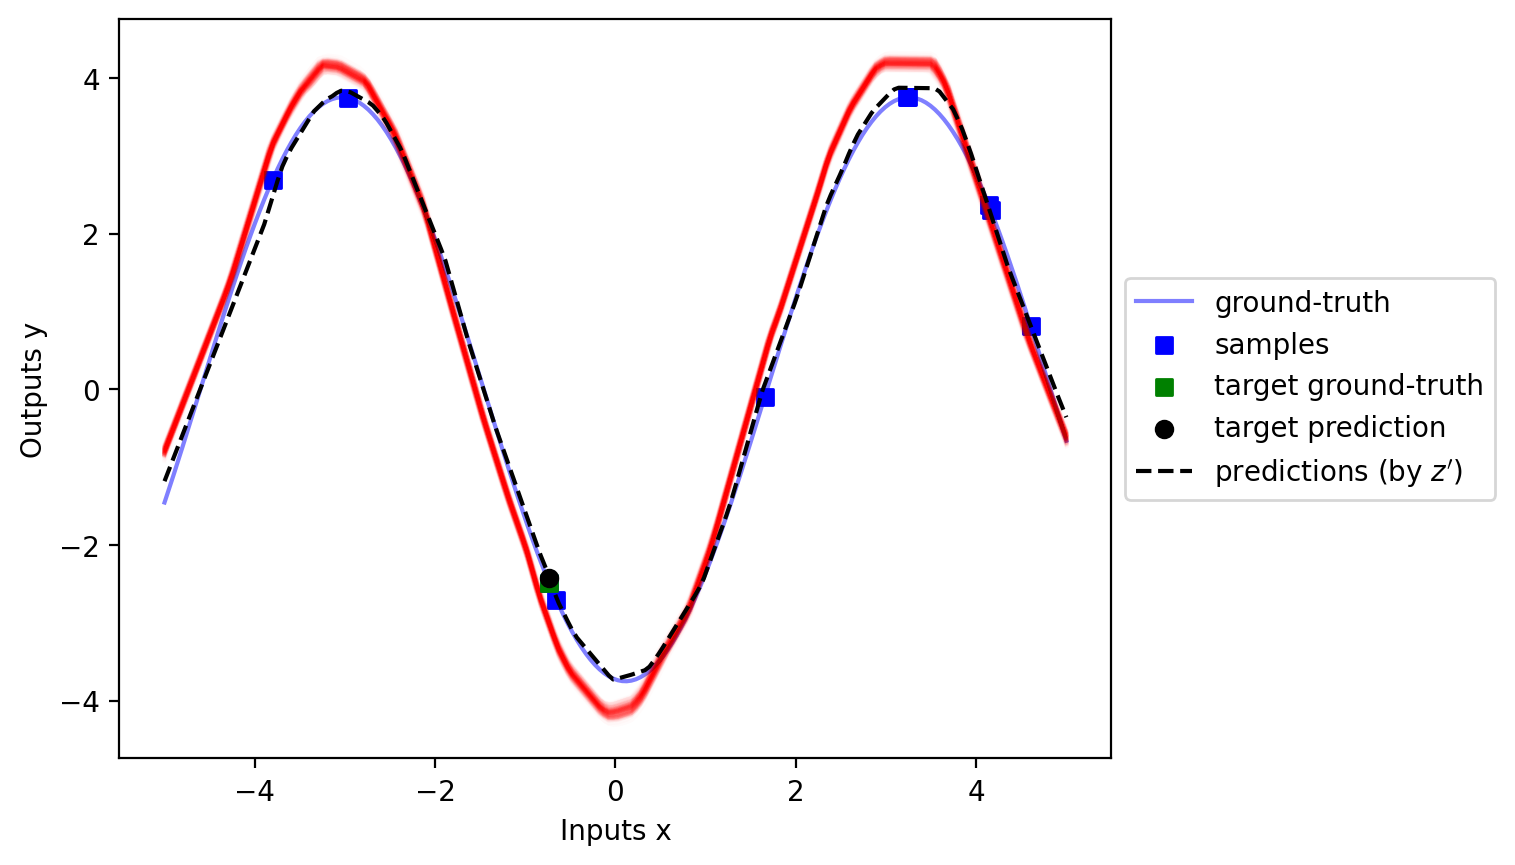

In [70]:
import matplotlib.pyplot as plt

x = np.linspace(-5, 5, 200)

for i in range(10):
    # Plot ground-truth
    y = amp * np.sin(x - phase)
    plt.plot(x, y, label=f"ground-truth", color='blue', alpha=.5, zorder=20)

    # Plot samples
    plt.scatter(sample_xs, sample_ys, label=f"samples", color='blue', marker='s', zorder=30)

    # Plot all predictions
    # plt.scatter(sample_xs, yhat, marker='o', color='blue', label=f"predictions")

    # Plot target x,y (sample i of batch 0), and its prediction
    x_i = sample_xs[0, i].item()
    y_i = sample_ys[0, i].item()
    yhat_i = y_pred[0, i].item()
    plt.scatter(x_i, y_i, marker='s', color='green', label=f"target ground-truth", zorder=60)
    plt.scatter(x_i, yhat_i, marker='o', color='k', label=f"target prediction", zorder=70)

    # Plot the predicted latent program (z_mu_i) conditioned on the 9 other samples
    z_mu_i = z_mu[0, i]
    z_pr_i = z_prime[0, i]
    x_prep = torch.Tensor(x).unsqueeze(1).to(device)  # (100, 1)
    y_pred_z_mu_i = lpn.decode(z_mu_i, x_prep).detach().cpu().numpy()
    y_pred_z_pr_i = lpn.decode(z_pr_i, x_prep).detach().cpu().numpy()
    # plt.plot(x, yhat_z_mu_i, label="predictions (by $z^{(i)}_\\mu$)",
    #          color='k', linestyle='dashed', alpha=1, zorder=50)
    plt.plot(x, y_pred_z_pr_i, label="predictions (by $z'$)",
             color='k', linestyle='dashed', alpha=1, zorder=50)

    # Plot some sampled latent programs
    n_samples = 200
    for j in range(n_samples):
        z_init = lpn.sample_latents(z_mu_i, z_logvar[0, i])
        y_pred_z = lpn.decode(z_init, x_prep).detach().cpu().numpy()
        # label = f"predictions (by $z \\sim N(\\mu_z, \\Sigma_z)$)"
        plt.plot(x, y_pred_z, color='red', alpha=3/n_samples, zorder=40)

    plt.xlabel("Inputs x")
    plt.ylabel("Outputs y")
    # plt.title("Outputs vs Inputs")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [ ]:
sample_xs[0, 0]

tensor([0.3108])

In [ ]:
x_prep = torch.Tensor(x).unsqueeze(1).to(device)  # (100, 1)
x_prep.shape

torch.Size([100, 1])

In [ ]:
z_sample[0, 0].shape

torch.Size([2])

### [WIP] Algorithm 1: Test-Time Inference

In [ ]:
# # Input
# inputs, outputs_pred, amp, phase = [torch.Tensor(arr) for arr in data_gen.generate()]
# # Context: n=10 input-output pairs (x_i, y_i)
# ctx_inputs = inputs[:, :-1, :]
# ctx_outputs = outputs_pred[:, :-1, :]
# # Test input x_{n+1}
# test_inputs = inputs[:, -1, :].unsqueeze(1)
# test_outputs = outputs_pred[:, -1, :].unsqueeze(1)
# number of gradient steps

### Plotting sample tasks

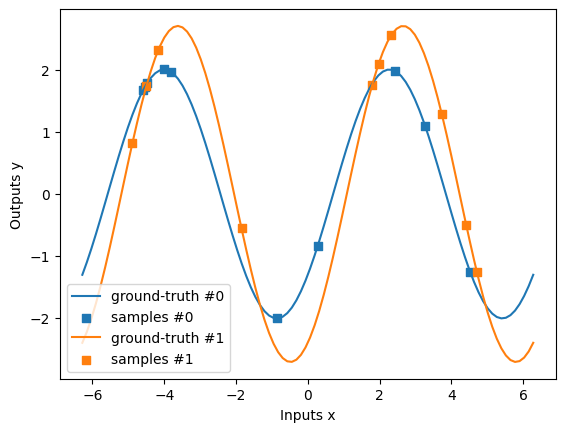

In [ ]:
import matplotlib.pyplot as plt

# Plot each set of inputs and outputs as a separate line
for i in range(min(2, inputs_np.shape[0])):
    x = np.linspace(-2 * np.pi, 2 * np.pi, 100)
    y = amp_np[i] * np.sin(x - phase_np[i])
    plt.plot(x, y, label=f"ground-truth #{i}")
    plt.scatter(inputs_np[i], outputs_np[i], marker='s', label=f"samples #{i}")
    # plt.plot(init_inputs[i], outputs[i], label=f"Line {i+1}")

plt.xlabel("Inputs x")
plt.ylabel("Outputs y")
# plt.title("Outputs vs Inputs")
plt.legend()
plt.show()